# Section 3: Python & Hugging Face

## Load the Dataset

In [1]:
import pandas as pd

df = pd.read_csv('../data/traininig-dataset.csv')

print(f"Dataset loaded: {len(df)} samples")

print(f"\nLabel distribution:")
label_counts = df['label'].value_counts().reset_index()
label_counts.columns = ['label', 'count']
print(label_counts.to_string(index=False))

print(f"\nFirst few rows:")
print(df.head(3).to_string(index=False))

Dataset loaded: 50 samples

Label distribution:
 label  count
     1     26
     0     24

First few rows:
note_id                                                                                                                                                                                                                                                                                                                                                                                                          text  label
  N2013 Patient reports flooding during menses since menarche, describing soaking a pad every 1–2 hours with episodes of 'flooding'. Associated symptoms include sleep disruption from overnight changes; iron studies pending. Relevant history: endometriosis history. Impact: requires planning around menses. Management discussed: discussed tranexamic acid; patient prefers non-hormonal options at this time.      1
  N2015                                 Patient reports heavy mense

## Tokenize the Text Field

### Split into Train and Validation Sets

In [2]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

print(f"\nTrain: {len(train_df)} samples | Validation: {len(val_df)} samples")


Train: 40 samples | Validation: 10 samples


### Load Tokenizer

In [3]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

### Tokenization Function

In [4]:
from datasets import Dataset

def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=128)

### Convert to Hugging Face Datasets and Tokenize

In [5]:
train_dataset = Dataset.from_pandas(train_df[['text', 'label']]).map(tokenize_function, batched=True)
val_dataset = Dataset.from_pandas(val_df[['text', 'label']]).map(tokenize_function, batched=True)

train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

print("\nTokenization complete!")

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]


Tokenization complete!


## Train a Small Classifier

### Load Model

In [6]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Training Configuration

In [7]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    save_strategy="no",  # or epoch
    logging_steps=5,
    seed=42
)

### Metrics Function

In [8]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions)
    return {'accuracy': accuracy, 'f1': f1}

### Initialize Trainer

In [9]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

### Train the Model

In [10]:
print("\nStarting training (2 epochs)...")
trainer.train()
print("Training complete!")


Starting training (2 epochs)...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.588400,0.370720,1.000000,1.000000
2,0.314200,0.230183,1.000000,1.000000


Training complete!


### Report Validation Accuracy and F1 Score

In [11]:
eval_results = trainer.evaluate()

print("\n" + "="*50)
print("VALIDATION RESULTS")
print("="*50)
print(f"Accuracy: {eval_results['eval_accuracy']:.4f} ({eval_results['eval_accuracy']*100:.2f}%)")
print(f"F1 Score: {eval_results['eval_f1']:.4f}")
print("="*50)


VALIDATION RESULTS
Accuracy: 1.0000 (100.00%)
F1 Score: 1.0000


# Section 4: Confusion Matrix

## Generate Confusion Matrix

In [12]:
from sklearn.metrics import confusion_matrix

predictions = trainer.predict(val_dataset)
pred_labels = np.argmax(predictions.predictions, axis=-1)
true_labels = val_df['label'].values

cm = confusion_matrix(true_labels, pred_labels)

## Plot Confusion Matrix


Done!


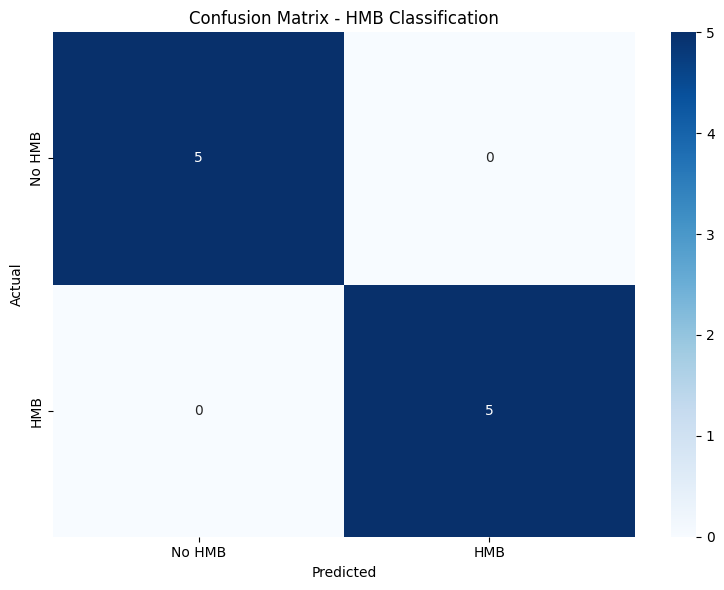

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No HMB', 'HMB'],
            yticklabels=['No HMB', 'HMB'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - HMB Classification')
plt.tight_layout()

print("\nDone!")